In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv('/content/drive/My Drive/a40_new.csv')
df.head()

,LinkRef,LinkDescription,Date,TimePeriod,AverageJT,AverageSpeed,DayType,LinkLength,Flow
0,AL2471,A40 between A4137 and A49 (AL2471),01/01/2010,00:00:00,270.88,101.80,14,7.66,4.0
1,AL2471,A40 between A4137 and A49 (AL2471),01/01/2010,00:15:00,303.63,90.82,14,7.66,3.0
2,AL2471,A40 between A4137 and A49 (AL2471),01/01/2010,00:30:00,318.10,86.69,14,7.66,14.0
3,AL2471,A40 between A4137 and A49 (AL2471),01/01/2010,00:45:00,323.02,85.37,14,7.66,11.0
4,AL2471,A40 between A4137 and A49 (AL2471),01/01/2010,01:00:00,260.15,106.00,14,7.66,8.0


In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
TRAIN_SPLIT = 120000

In [ ]:
tf.random.set_seed(13)

In [ ]:
uni_data = df['AverageSpeed']
uni_data.index = df['TimePeriod']
uni_data.head()

TimePeriod
00:00:00    101.80
00:15:00     90.82
00:30:00     86.69
00:45:00     85.37
01:00:00    106.00
Name: AverageSpeed, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53a441bf60>],
      dtype=object)

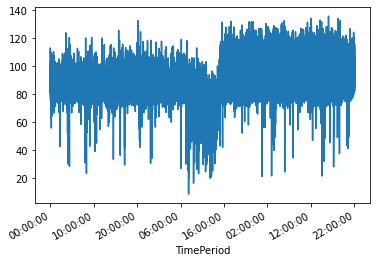

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [ ]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n target speed predict')
print (y_train_uni[0])

Single window of past history
[[ 1.66997587]
 [ 0.38892346]
 [-0.09292959]
 [-0.24693589]
 [ 2.15999591]
 [ 0.87194322]
 [-0.22593503]
 [ 0.56743076]
 [ 1.34796269]
 [ 0.99328152]
 [ 0.17424801]
 [-0.49777949]
 [-0.74862308]
 [ 0.59076505]
 [ 2.99069656]
 [ 0.59076505]
 [ 0.4332586 ]
 [ 0.82410793]
 [-0.85246066]
 [-0.15359874]]

 target speed predict
0.6140993359226122


In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

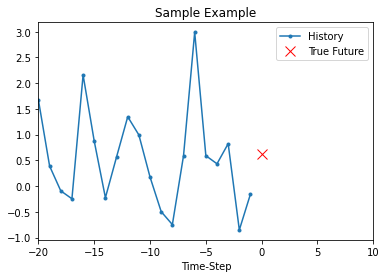

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [ ]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

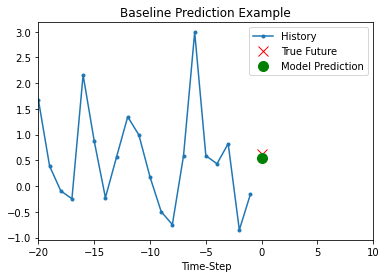

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3800 - val_loss: 0.6543
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4451 - val_loss: 0.5256
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3954 - val_loss: 0.5487
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3743 - val_loss: 0.5330
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4405 - val_loss: 0.5452
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3390 - val_loss: 0.5328
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4569 - val_loss: 0.4936
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3458 - val_loss: 0.5353
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3939 - val_loss: 0.4993
Epoch 10/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3941 - val_loss: 0.5314

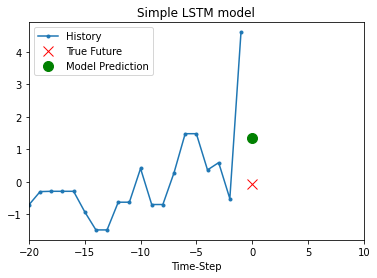

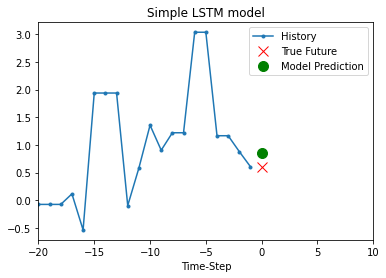

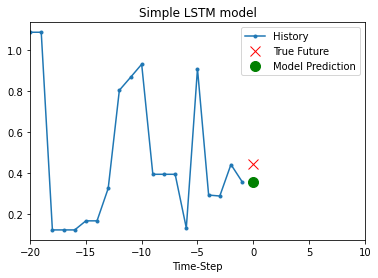

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [ ]:
df.columns

Index(['LinkRef', 'LinkDescription', 'Date', 'TimePeriod', 'AverageJT',
       'AverageSpeed', 'DayType', 'LinkLength', 'Flow'],
      dtype='object')

In [ ]:
features_considered = ['AverageJT', 'AverageSpeed', 'DayType','LinkLength','Flow']

In [ ]:
features = df[features_considered]
features.index = df['TimePeriod']
features.head()

,AverageJT,AverageSpeed,DayType,LinkLength,Flow
TimePeriod,,,,,
00:00:00,270.88,101.80,14,7.66,4.0
00:15:00,303.63,90.82,14,7.66,3.0
00:30:00,318.10,86.69,14,7.66,14.0
00:45:00,323.02,85.37,14,7.66,11.0
01:00:00,260.15,106.00,14,7.66,8.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53a4eab390>,
      dtype=object)

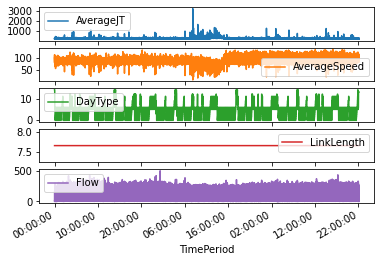

In [ ]:
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [ ]:
dataset = (dataset-data_mean)/data_std

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 5)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 11ms/step - loss: 0.3821 - val_loss: 1.1363
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.5189 - val_loss: 0.7217
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.4465 - val_loss: 0.9708
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.4230 - val_loss: 0.8956
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.5097 - val_loss: 0.9243
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3534 - val_loss: 1.0315
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.5680 - val_loss: 0.7079
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3477 - val_loss: 0.9552
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.4819 - val_loss: 0.6709
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.4185 - val_loss: 0.92

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

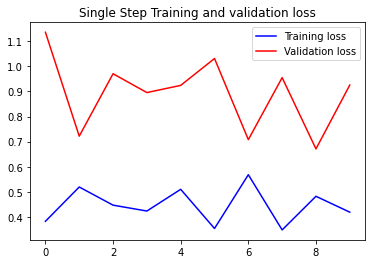

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

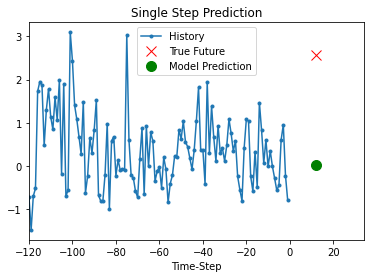

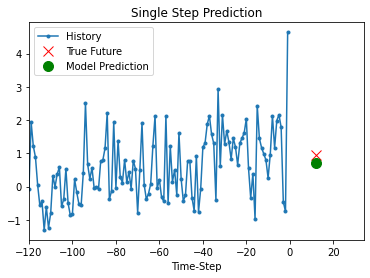

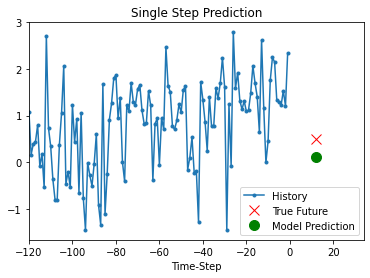

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [ ]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 5)

 Target temperature to predict : (72,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

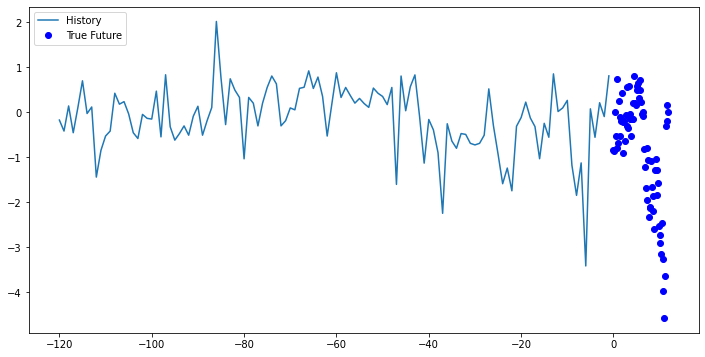

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')